In [1]:
!pip install tensorflow-datasets --quiet
!pip install pydot --quiet
!pip install transformers --quiet

     |████████████████████████████████| 5.5 MB 9.2 MB/s 
     |████████████████████████████████| 182 kB 57.7 MB/s 
     |████████████████████████████████| 7.6 MB 55.9 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#let's make longer output readable without scrolling
from pprint import pprint

In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# define paths in colab
dataset_path = 'drive/MyDrive/Colab Notebooks/w266_project_data'
csv_path = 'drive/MyDrive/Colab Notebooks/w266_project_predictions/'
model_path = 'drive/MyDrive/Colab Notebooks/w266_project_models/'

In [5]:
# a list of model's output CSV file
output_file_names = ['davidson_t5_test_output.csv', 'davidson_xsum_output.csv', 'davidson_bart_cnn_test.csv', 
                     'davidson_paradetox_output.csv']

## Models

In [6]:
max_length = 65

### BERT Tweet Model

In [7]:
model_checkpoint = 'vinai/bertweet-base'
model_name = 'davidson_bertweet_weights.hdf5'

In [8]:
from transformers import AutoModel, AutoTokenizer, TFAutoModel

bertweet_model = TFAutoModel.from_pretrained(model_checkpoint)
bertweet_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### load fine-tuned BERTWEET to predict data

In [9]:
def create_bertweet_model(checkpoint = model_checkpoint,
                                hidden_size = 66, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bertweet_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [10]:
pooled_bertweet_model = create_bertweet_model()

In [11]:
# The model weights (that are considered the best) are loaded into the
# model.
checkpoint_file = model_path + model_name
pooled_bertweet_model.load_weights(checkpoint_file)

#### load T5 translated data

In [12]:
output_file_name = 'davidson_t5_test_output.csv'
df_bartweet_predictions = pd.read_csv(csv_path + output_file_name)
df_bartweet_predictions['class'] = 2
df_bartweet_predictions.head()

,test_inputs,test_predictions,class
0,"summarize: ""Why would you wanna be the Green R...",Why would you wanna be the Green Ranger? He's ...,2
1,summarize: #HolySpirit God still share HIS #Se...,#HolySpirit God still share HIS #Secrets Amos ...,2
2,summarize: pancakes trash,pancakes are not good,2
3,"summarize: The KFAN mock draft continues, Clev...","The KFAN mock draft continues, Cleveland is ""o...",2
4,summarize: I be telling Mcgirt music ain't eno...,I be telling Mcgirt music ain't enough.You got...,2


In [13]:
len(df_bartweet_predictions)

2470

In [14]:
test_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

predictions = pooled_bertweet_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
prediction_classes = predictions.argmax(axis=-1)
#tweet_cf = confusion_matrix(df_bartweet_predictions['class'], prediction_classes)
#sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

78/78 [==============================] - 17s 143ms/step


In [15]:
predictions.argmax(axis=-1)

array([2, 2, 2, ..., 2, 1, 2])

In [16]:
np.unique(prediction_classes, return_counts=True)

(array([0, 1, 2]), array([   2, 1076, 1392]))

In [17]:
pd.options.display.max_colwidth = 100
df_bartweet_predictions[2468:]['test_inputs']

2468    summarize: Fuck you bitches who send dudes to child support court just because you're petty
2469               summarize: Kanye &gt; Tupac........ "are you serious?" Yep bitch keep it moving.
Name: test_inputs, dtype: object

In [18]:
df_bartweet_predictions[2468:]['test_predictions']

2468    you send dudes to child support court just because you're petty
2469    Kanye &gt; Tupac........ "are you serious?" Yep keep it moving.
Name: test_predictions, dtype: object

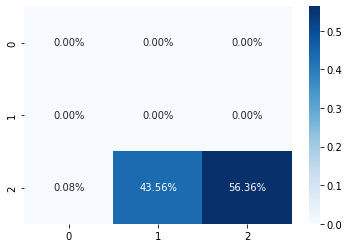

In [19]:
tweet_cf = confusion_matrix(df_bartweet_predictions['class'], prediction_classes)
sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

#### load BERTWEET balanced model

In [20]:
model_name = 'davidson_bertweet_balanced_weights.hdf5'

In [21]:
balanced_bertweet_model = create_bertweet_model()

In [22]:
checkpoint_file = model_path + model_name
balanced_bertweet_model.load_weights(checkpoint_file)

In [23]:
#test_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

balanced_predictions = balanced_bertweet_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
balanced_prediction_classes = balanced_predictions.argmax(axis=-1)

78/78 [==============================] - 14s 137ms/step


In [24]:
balanced_predictions.argmax(axis=-1)

array([2, 2, 2, ..., 2, 0, 2])

In [25]:
np.unique(balanced_prediction_classes, return_counts=True)

(array([0, 1, 2]), array([ 436,  578, 1456]))

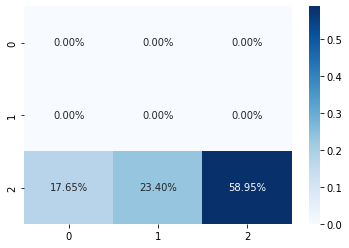

In [26]:
tweet_cf = confusion_matrix(df_bartweet_predictions['class'], balanced_prediction_classes)
sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

### BERT Large Model

In [27]:
model_checkpoint = 'bert-large-uncased'
model_name = 'davidson_bertlarge_weights.hdf5'

In [28]:
from transformers import BertTokenizer, TFBertModel

bert_large_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_large_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### load fine-tuned BERT Large to predict data

In [29]:
def create_bert_large_model(checkpoint = model_checkpoint,
                                hidden_size = 66, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_large_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [30]:
pooled_bert_large_model = create_bert_large_model()

In [31]:
# The model weights (that are considered the best) are loaded into the
# model.
checkpoint_file = model_path + model_name
pooled_bert_large_model.load_weights(checkpoint_file)

In [33]:
bert_large_predictions = pooled_bert_large_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
bert_large_prediction_classes = predictions.argmax(axis=-1)
#tweet_cf = confusion_matrix(df_bartweet_predictions['class'], prediction_classes)
#sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

InvalidArgumentError: ignored

In [ ]:
bert_large_predictions.argmax(axis=-1)

In [ ]:
np.unique(bert_large_prediction_classes, return_counts=True)

In [ ]:
pd.options.display.max_colwidth = 100
df_bartweet_predictions[2468:]['test_inputs']

In [ ]:
df_bartweet_predictions[2468:]['test_predictions']

In [ ]:
tweet_cf = confusion_matrix(df_bartweet_predictions['class'], bert_large_prediction_classes)
sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

#### load BERT LARGE balanced model

In [ ]:
model_name = 'davidson_bertlarge_balanced_weights.hdf5'

In [ ]:
balanced_bert_large_model = create_bert_large_model()

In [ ]:
checkpoint_file = model_path + model_name
balanced_bert_large_model.load_weights(checkpoint_file)

In [ ]:
#test_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

balanced_bert_large_predictions = balanced_bert_large_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
balanced_bert_large_prediction_classes = balanced_bert_large_predictions.argmax(axis=-1)

In [ ]:
balanced_bert_large_predictions.argmax(axis=-1)

In [ ]:
np.unique(balanced_bert_large_prediction_classes, return_counts=True)

In [ ]:
tweet_cf = confusion_matrix(df_bartweet_predictions['class'], balanced_bert_large_prediction_classes)
sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
for output_file_name in output_file_names:
  df_bartweet_predictions = pd.read_csv(csv_path + output_file_name)

  # 0 - hate speech 1 - offensive language 2 - neither
  df_bartweet_predictions['class'] = '2'

  # tokenize dataset
  #train_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  #valid_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  test_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

  # model.fit()
  pooled_bertweet_model = create_bertweet_model()
  predictions = pooled_bertweet_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
  prediction_classes = predictions.argmax(axis=-1)
  tweet_cf = confusion_matrix(df_bartweet_predictions['class'], prediction_classes)
  sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
prediction_classes

In [ ]:
len(prediction_classes)

In [ ]:
np.unique(prediction_classes, return_counts=True)

In [ ]:
for output_file_name in output_file_names:
  df_bartweet_predictions = pd.read_csv(csv_path + output_file_name)
  df_bartweet_predictions['class'] = 0

  # tokenize dataset
  train_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  valid_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
  test_encodings = bertweet_tokenizer(list(df_bartweet_predictions['test_predictions']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

  # model.fit()
  pooled_bertweet_model = create_bertweet_model()
  pooled_bertweet_model_history = pooled_bertweet_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(df_bartweet_predictions['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(df_bartweet_predictions['class'])),    
                                                  batch_size=32, 
                                                  epochs=1) 
  bertweet_score = pooled_bertweet_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(df_bartweet_predictions['class'])) 
  display(output_file_name)
  print('Test loss:', bertweet_score[0]) 
  print('Test accuracy:', bertweet_score[1]) 



  #display(output_file_name)
  #display(pd.concat({k: pd.DataFrame(v) for k, v in rouge_results.items()}))
  print()

In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bertweet_tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bertweet_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bertweet_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
train_encodings.input_ids.shape

print('train_encodings shape = ', train_encodings.input_ids.shape)
print('valid_encodings shape = ', valid_encodings.input_ids.shape)
print('test_encodings shape = ', test_encodings.input_ids.shape)

In [ ]:
train_encodings

In [ ]:
pooled_bertweet_model = create_bertweet_model()
pooled_bertweet_model_history = pooled_bertweet_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback]) 
bertweet_score = pooled_bertweet_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', bertweet_score[0]) 
print('Test accuracy:', bertweet_score[1]) 

In [ ]:
predictions = pooled_bertweet_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
prediction_classes = predictions.argmax(axis=-1)

In [ ]:
tweet_cf = confusion_matrix(testing_tweets['class'], prediction_classes)
sns.heatmap(tweet_cf/np.sum(tweet_cf), annot=True, fmt='.2%', cmap='Blues')

### BERT Uncase Model

In [ ]:
model_checkpoint = 'bert-base-uncased'
model_name = 'davidson_bert_weights.hdf5'

In [ ]:
# Place to save CHECKPOINTS
checkpoint_filepath = model_path + model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [ ]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
train_encodings.input_ids.shape

print('train_encodings shape = ', train_encodings.input_ids.shape)
print('valid_encodings shape = ', valid_encodings.input_ids.shape)
print('test_encodings shape = ', test_encodings.input_ids.shape)

train_encodings shape =  (19826, 65)
valid_encodings shape =  (2478, 65)
test_encodings shape =  (2479, 65)


In [ ]:
train_encodings

{'input_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[  101,  8840,  2140, ...,     0,     0,     0],
       [  101,  2123,  1005, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       ...,
       [  101,  8112,  7110, ...,     0,     0,     0],
       [  101,  9152, 23033, ...,     0,     0,     0],
       [  101,  1045,  5223, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [ ]:
def create_bert_model(checkpoint = model_checkpoint,
                                hidden_size = 66, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [ ]:
pooled_bert_model = create_bert_model()
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback]) 
bert_score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', bert_score[0]) 
print('Test accuracy:', bert_score[1]) 

78/78 [==============================] - 2s 31ms/step - loss: 0.2901 - accuracy: 0.9040
Test loss: 0.2901492416858673
Test accuracy: 0.903993546962738


In [ ]:
pooled_bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 65)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                            

In [ ]:
predictions = pooled_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
prediction_classes = predictions.argmax(axis=-1)

78/78 [==============================] - 6s 30ms/step


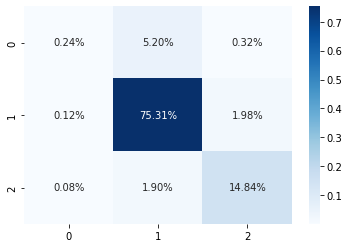

In [ ]:
bert_cf = confusion_matrix(testing_tweets['class'], prediction_classes)
sns.heatmap(bert_cf/np.sum(bert_cf), annot=True, fmt='.2%', cmap='Blues')

### BERT Large Uncase Model

In [ ]:
model_checkpoint = 'bert-large-uncased'
model_name = 'davidson_bertlarge_weights.hdf5'

In [ ]:
# Place to save CHECKPOINTS
checkpoint_filepath = model_path + model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [ ]:
from transformers import BertTokenizer, TFBertModel

bert_large_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_large_model = TFBertModel.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_large_tokenizer(list(training_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_large_tokenizer(list(valid_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_large_tokenizer(list(testing_tweets['tweet']), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
train_encodings.input_ids.shape

print('train_encodings shape = ', train_encodings.input_ids.shape)
print('valid_encodings shape = ', valid_encodings.input_ids.shape)
print('test_encodings shape = ', test_encodings.input_ids.shape)

train_encodings shape =  (19826, 65)
valid_encodings shape =  (2478, 65)
test_encodings shape =  (2479, 65)


In [ ]:
train_encodings

{'input_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[  101,  8840,  2140, ...,     0,     0,     0],
       [  101,  2123,  1005, ...,     0,     0,     0],
       [  101,  1045,  1005, ...,     0,     0,     0],
       ...,
       [  101,  8112,  7110, ...,     0,     0,     0],
       [  101,  9152, 23033, ...,     0,     0,     0],
       [  101,  1045,  5223, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(19826, 65), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [ ]:
def create_bert_large_model(checkpoint = model_checkpoint,
                                hidden_size = 66, 
                                dropout=0.3,
                                learning_rate=0.00005):
  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
  """
  #bert_model = TFBertModel.from_pretrained(checkpoint)                                              
  ### YOUR CODE HERE

  input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
  token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
  attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

  bert_inputs = {'input_ids': input_ids,
  'token_type_ids': token_type_ids,
  'attention_mask': attention_mask
  }      

  bert_out = bert_large_model(bert_inputs)
  pooled_token = bert_out[1]

  hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_token)
  hidden = tf.keras.layers.Dropout(dropout, name='dropout_layer')(hidden)

  classification = tf.keras.layers.Dense(3, activation='softmax',name='classification_layer')(hidden)

  classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

  classification_model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
      metrics=['accuracy'])


  ### END YOUR CODE
  return classification_model

In [ ]:
pooled_bert_large_model = create_bert_large_model()
pooled_bert_large_model_history = pooled_bert_large_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  np.array(training_tweets['class']),   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  np.array(valid_tweets['class'])),    
                                                  batch_size=32, 
                                                  epochs=1,
                                                  callbacks=[model_checkpoint_callback]) 
bert_large_score = pooled_bert_large_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  np.array(testing_tweets['class'])) 

print('Test loss:', bert_large_score[0]) 
print('Test accuracy:', bert_large_score[1]) 

78/78 [==============================] - 6s 73ms/step - loss: 0.6628 - accuracy: 0.7741
Test loss: 0.6628483533859253
Test accuracy: 0.7741024494171143


In [ ]:
pooled_bert_large_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 65)]         0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 65)]        0           []                               
 er)                                                                                              
                                                                                            

In [ ]:
predictions = pooled_bert_large_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
prediction_classes = predictions.argmax(axis=-1)

78/78 [==============================] - 12s 74ms/step


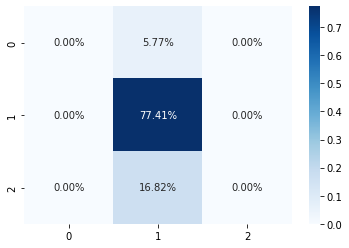

In [ ]:
large_cf = confusion_matrix(testing_tweets['class'], prediction_classes)
sns.heatmap(large_cf/np.sum(large_cf), annot=True, fmt='.2%', cmap='Blues')

### Outputs

In [ ]:
output_dic = {'loss': [bertweet_score[0], bert_score[0], bert_large_score[0]], 'accuracy': [bertweet_score[1], bert_score[1], bert_large_score[1]]}

In [ ]:
output_dic

{'loss': [0.25753170251846313, 0.2901492416858673, 0.6628483533859253],
 'accuracy': [0.9072206616401672, 0.903993546962738, 0.7741024494171143]}

In [ ]:
# row 0 = bertweet
# row 1 = bert uncase
# row 2 = bert large uncase

df_outpout = pd.DataFrame(data=output_dic)
df_outpout

,loss,accuracy
0,0.257532,0.907221
1,0.290149,0.903994
2,0.662848,0.774102
